In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [102]:
from google.colab import files

uploaded = files.upload()

In [103]:
df = pd.read_csv('Assignment-data-diabetes.csv')
df_uncleaned = df.copy()

In [104]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# __1. Preprocessing__

## __a. Identify missing, inconsistent, or corrupted values__

<Axes: >

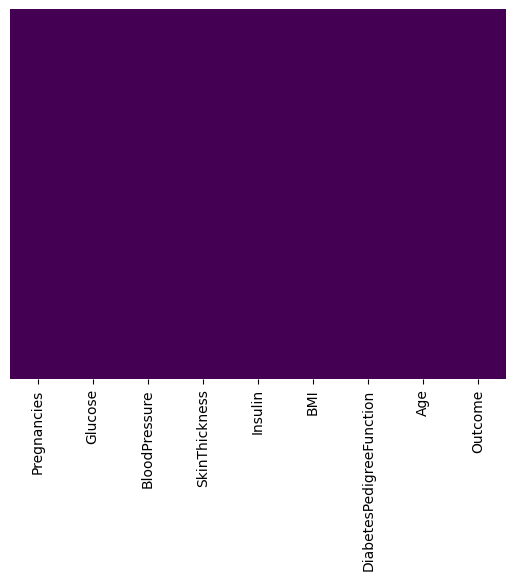

In [106]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### __It is evident from the above heatmap that no data is missing in the given dataset but in some feature columns, it has been noticed that some values are 0 like in SkinThickness, etc. which does not make sense. So we have to impute all those values__

<Axes: >

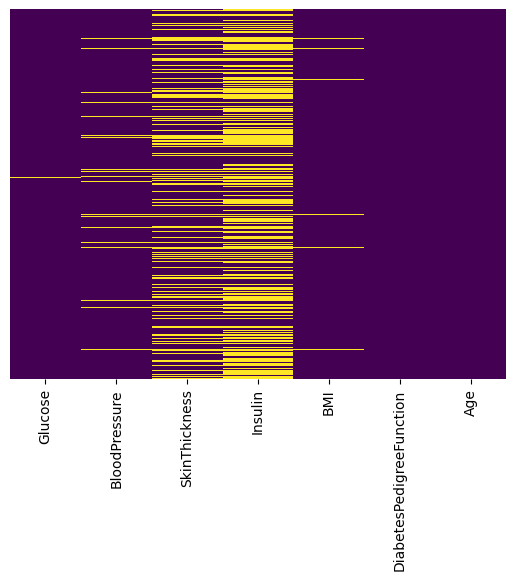

In [107]:
cols_to_plot = [col for col in df.columns if col not in ['Pregnancies', 'Outcome']]
sns.heatmap((df[cols_to_plot] == 0).astype(int), yticklabels=False, cbar=False, cmap='viridis')

## __b. Apply appropriate handling strategies__

In [108]:
columns_with_zero_values_list = []
cols_except_Preg_and_Outcome = [col for col in df.columns if col not in ['Pregnancies', 'Outcome']]
for col in cols_except_Preg_and_Outcome:
  for item in df[col]:
    if item == 0:
      columns_with_zero_values_list.append(col)
      break

In [109]:
def impute_median(col_list):
  for col in col_list:
    non_zero_vals_df = df[df[col] != 0]
    median_val = non_zero_vals_df[[col, 'Outcome']].groupby(['Outcome'])[col].median().reset_index()
    print(f"Median value for {col} is \n{median_val}\n\n")
    median_dict = dict(zip(median_val['Outcome'], median_val[col]))
    df.loc[(df['Outcome'] == 0) & (df[col] == 0), col] = np.int64(median_dict[0])
    df.loc[(df['Outcome'] == 1) & (df[col] == 0), col] = np.int64(median_dict[1])

In [110]:
impute_median(columns_with_zero_values_list)

Median value for Glucose is 
   Outcome  Glucose
0        0    107.0
1        1    140.0


Median value for BloodPressure is 
   Outcome  BloodPressure
0        0           70.0
1        1           74.5


Median value for SkinThickness is 
   Outcome  SkinThickness
0        0           27.0
1        1           32.0


Median value for Insulin is 
   Outcome  Insulin
0        0    102.5
1        1    169.5


Median value for BMI is 
   Outcome   BMI
0        0  30.1
1        1  34.3




In [111]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,169,33.6,0.627,50,1
1,1,85,66,29,102,26.6,0.351,31,0
2,8,183,64,32,169,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<Axes: >

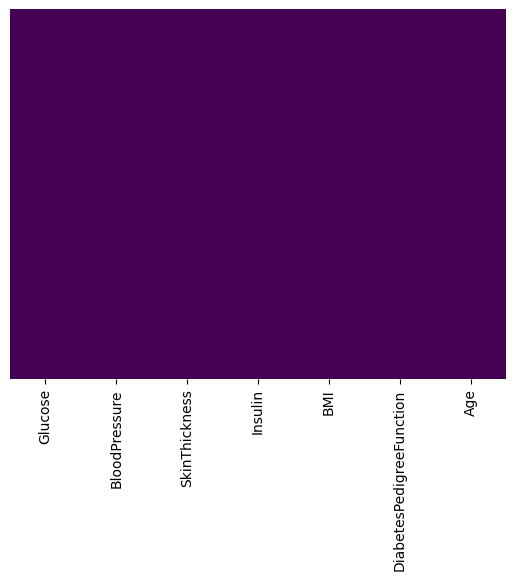

In [112]:
cols_to_plot = [col for col in df.columns if col not in ['Pregnancies', 'Outcome']]
sns.heatmap((df[cols_to_plot] == 0).astype(int), yticklabels=False, cbar=False, cmap='viridis')

### Now we can go for the outliers if any

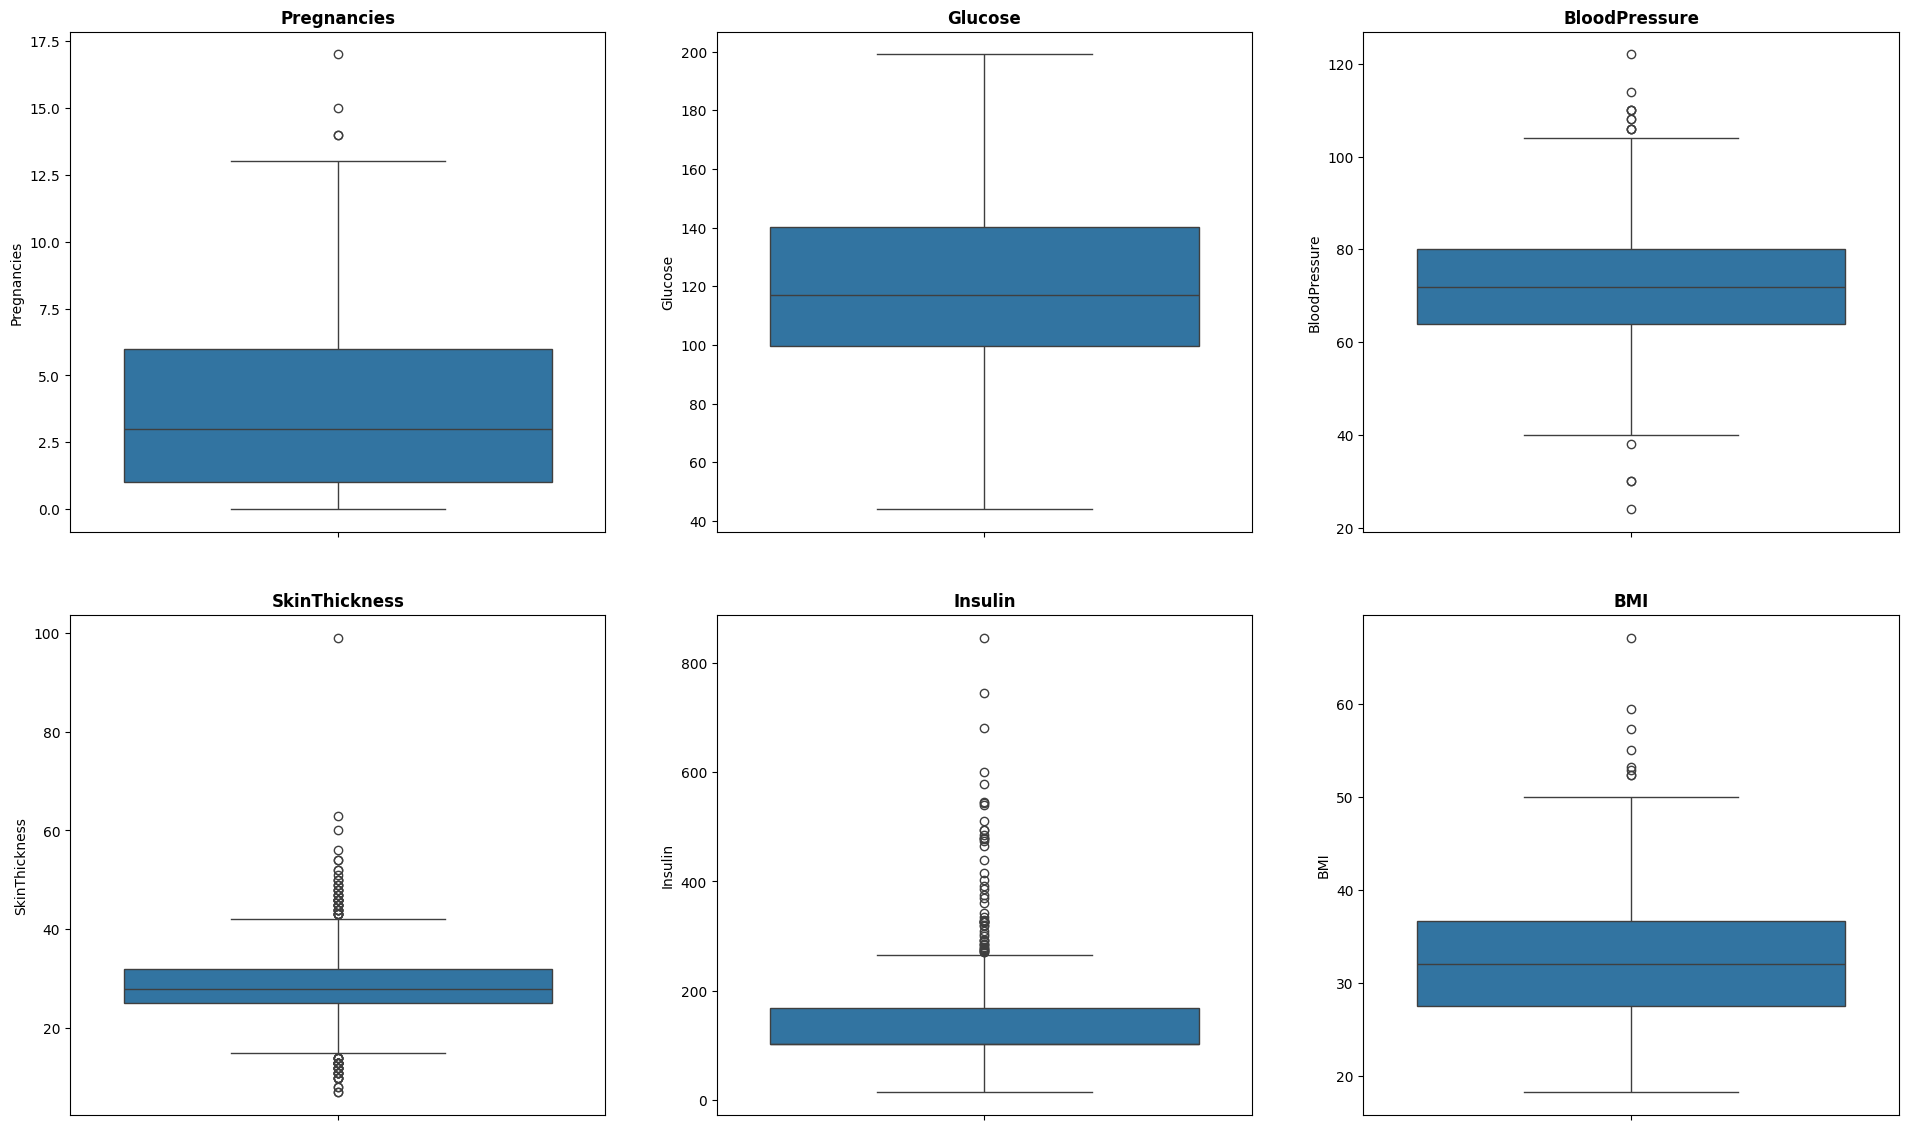

In [113]:
def plot_box_plots(df, col_list):
  n_cols = 3
  n_rows = math.ceil(len(col_list) / n_cols) + 1
  fig, axes = plt.subplots(n_rows,3, figsize=(20,18))
  axes = axes.flatten()

  for idx, col in enumerate(col_list):
    ax = axes[idx]
    sns.boxplot(data = df[col], ax = ax)

    ax.set_title(f'{col}', fontweight='bold', fontsize=12)


  for j in range(idx+1, len(axes)): #Removing the extra unused subplots
    fig.delaxes(axes[j])
  plt.tight_layout(pad=4.0)
  plt.show()



# Box plot for determining outliers and the skewness of the data
col_list = [col for col in df.columns if col not in ['DiabetesPedigreeFunction', 'Outcome', 'Age']]
plot_box_plots(df,col_list)

### __From these boxplots,__

 __1. Insulin contains highest number of outlier and also Insulin values of greater than 200 are medically impossible. Hence we can impute them accordingly.__

 __2. BloodPressure value below 40 seems absurd for a human being so we can impute it with valid ranges.__

 __Remaining outlier of other features may or maynot be possible since it requires more of domain knowledge of the Pima Indians.__

In [114]:
df.loc[df['Insulin'] > 200, 'Insulin'] = 200

In [115]:
median_bp = df.loc[(df['BloodPressure'] >= 60) & (df['BloodPressure'] <= 120), 'BloodPressure'].median()
df.loc[df['BloodPressure'] < 40, 'BloodPressure'] = median_bp

### __After removal of outliers from Insuling and BloodPressure, the box plots are  as follows__

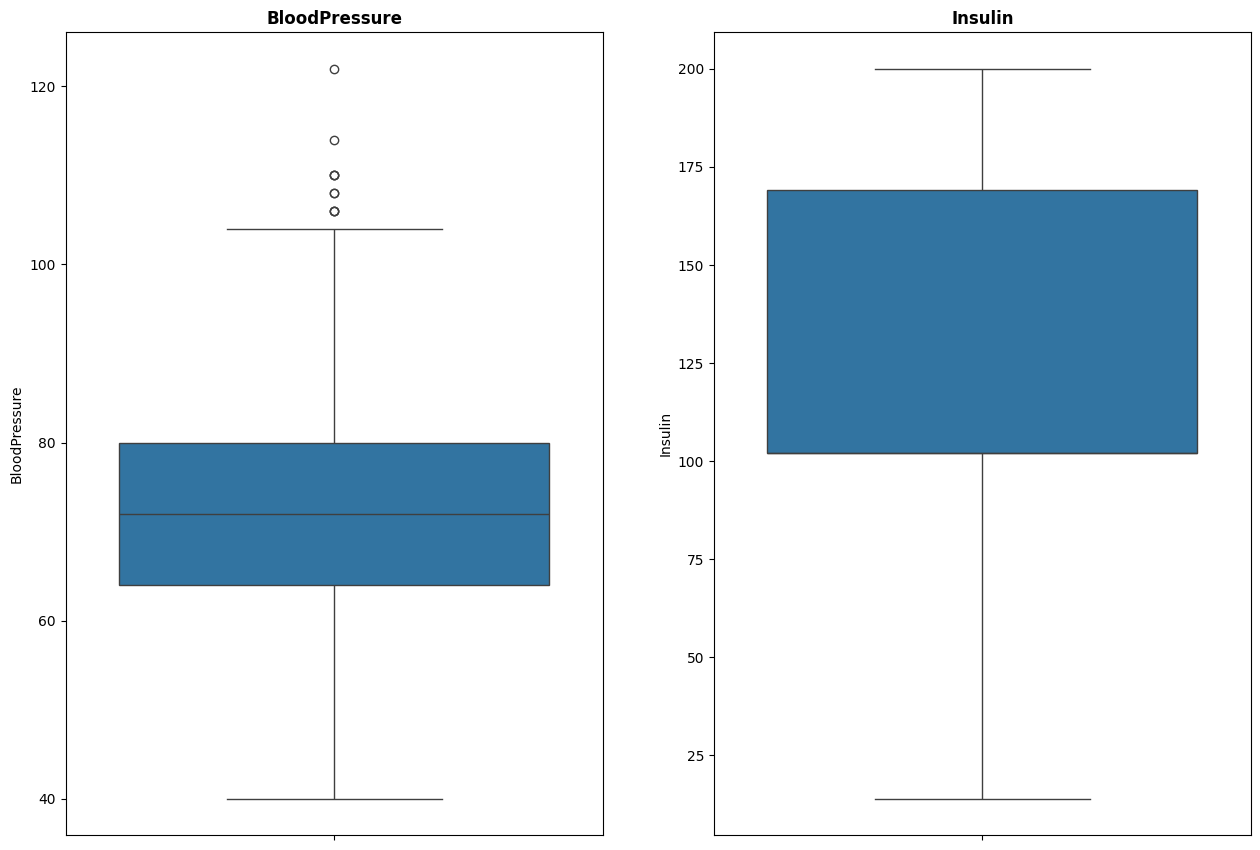

In [116]:
col_list = [col for col in df.columns if col in ['Insulin','BloodPressure']]
plot_box_plots(df,col_list)

## __c. Normalise/standardise all numerical columns__

In [117]:
from sklearn.preprocessing import StandardScaler

In [118]:
ss = StandardScaler()

In [119]:
df_Scaled = df.copy()
df_Scaled[df.columns[df.columns != 'Outcome']] = ss.fit_transform(df_Scaled[df.columns[df.columns != 'Outcome']])
df_Scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.864625,-0.051724,0.665181,0.903215,0.169761,0.468492,1.425995,1
1,-0.844885,-1.204727,-0.564291,-0.010112,-0.535175,-0.848239,-0.365061,-0.190672,0
2,1.233880,2.014265,-0.735147,0.327535,0.903215,-1.328153,0.604397,-0.105584,1
3,-0.844885,-1.073339,-0.564291,-0.685405,-0.706924,-0.630096,-0.920763,-1.041549,0
4,-1.141852,0.503310,-2.785416,0.665181,0.881747,1.551333,5.484909,-0.020496,1


## __d. Visualise data distributions before and after cleaning__

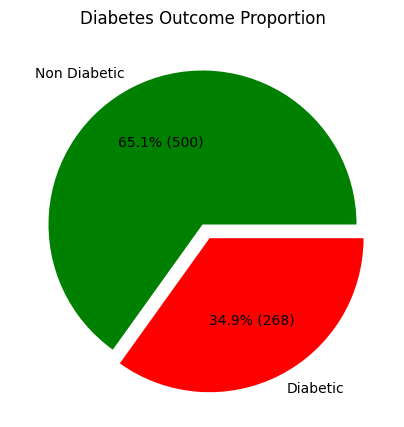

In [120]:
plt.figure(figsize=(5,5))
outcome_counts = df['Outcome'].value_counts()
labels = ["Non Diabetic" if idx == 0 else "Diabetic"  for idx in outcome_counts.index]
df['Outcome'].value_counts().plot(kind='pie', labels=labels, autopct=lambda pct: f'{pct:.1f}% ({int(round(pct * outcome_counts.sum() / 100))})', colors=['green', 'red'], explode=[0,0.1])
plt.title('Diabetes Outcome Proportion')
plt.ylabel('')
plt.show()

In [121]:
def create_histplot(df_cleaned, df_uncleaned, df_scaled, col_list):
  D_df_cleaned = df_cleaned[df_cleaned['Outcome'] == 1]
  H_df_cleaned = df_cleaned[df_cleaned['Outcome'] == 0]

  D_df_uncleaned = df_uncleaned[df_uncleaned['Outcome'] == 1]
  H_df_uncleaned = df_uncleaned[df_uncleaned['Outcome'] == 0]

  D_df_scaled = df_scaled[df_scaled['Outcome'] == 1]
  H_df_scaled = df_scaled[df_scaled['Outcome'] == 0]

  n_rows = math.ceil(len(col_list) / 2)
  fig, axes = plt.subplots(len(col_list), 3, figsize=(10, 4 * n_rows), sharey='row')
  for idx, col in enumerate(col_list):

    ax_uncleaned = axes[idx, 0]
    # Plotting diabetic data on Uncleaned Data
    sns.histplot(D_df_uncleaned[col], bins=10, kde=True, color='red', label='diabetic', stat='percent', alpha=0.5, ax=ax_uncleaned)

    # Plotting Non diabetic data on Uncleaned Data
    sns.histplot(H_df_uncleaned[col], bins=10, kde=True, color='green', label='healthy', stat='percent', alpha=0.5, ax=ax_uncleaned)

    ax_uncleaned.set_title(f"Uncleaned {col}")
    ax_uncleaned.set_xlabel(col)
    ax_uncleaned.set_ylabel('Percentage')
    ax_uncleaned.legend()


    ax_cleaned = axes[idx, 1]
    # Plotting diabetic data on cleaned Data
    sns.histplot(D_df_cleaned[col], bins=10, kde=True, color='red', label='diabetic', stat='percent', alpha=0.5, ax=ax_cleaned)

    # Plotting Non diabetic data on cleaned Data
    sns.histplot(H_df_cleaned[col], bins=10, kde=True, color='green', label='healthy', stat='percent', alpha=0.5, ax=ax_cleaned)

    ax_cleaned.set_title(f"Cleaned {col}")
    ax_cleaned.set_xlabel(col)
    ax_cleaned.set_ylabel('Percentage')
    ax_cleaned.legend()


    ax_scaled = axes[idx, 2]
    # Plotting diabetic data on Scaled Data
    sns.histplot(D_df_scaled[col], bins=10, kde=True, color='red', label='diabetic', stat='percent', alpha=0.5, ax=ax_scaled)

    # Plotting Non diabetic data on Scaled Data
    sns.histplot(H_df_scaled[col], bins=10, kde=True, color='green', label='healthy', stat='percent', alpha=0.5, ax=ax_scaled)

    ax_scaled.set_title(f"Scaled {col}")
    ax_scaled.set_xlabel(col)
    ax_scaled.set_ylabel('Percentage')
    ax_scaled.legend()

  plt.tight_layout()
  plt.show()


cols_to_plot = df.columns[df.columns != 'Outcome']

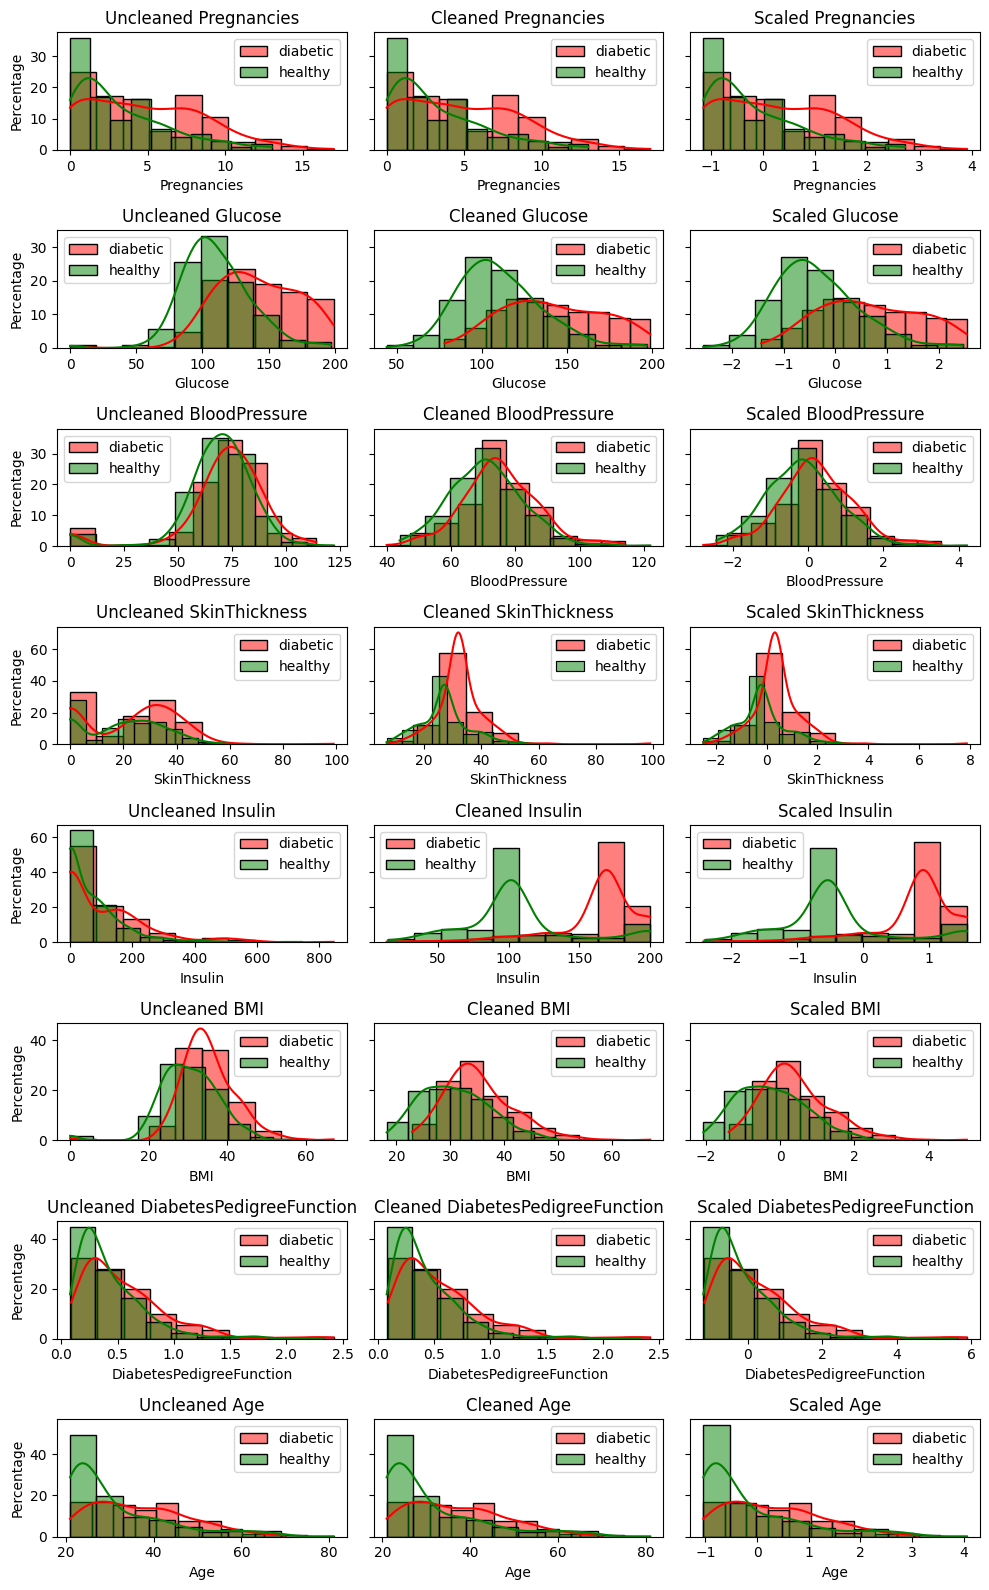

In [122]:
#Histogram before cleaning and after cleaning
create_histplot(df, df_uncleaned, df_Scaled, cols_to_plot)

### It is evident from these plots which shows comparative histogram plots of all the features except the __Outcome__ column which is the target variable that after cleaning and imputation, we got a good distribution of data

 __Here we are plotting the correlation in two different sets of heatmap__
 __-> First showcasing the correlation of the the target column with other features.__
 __-> Second showcasing the correlation between all features and outcomes.__

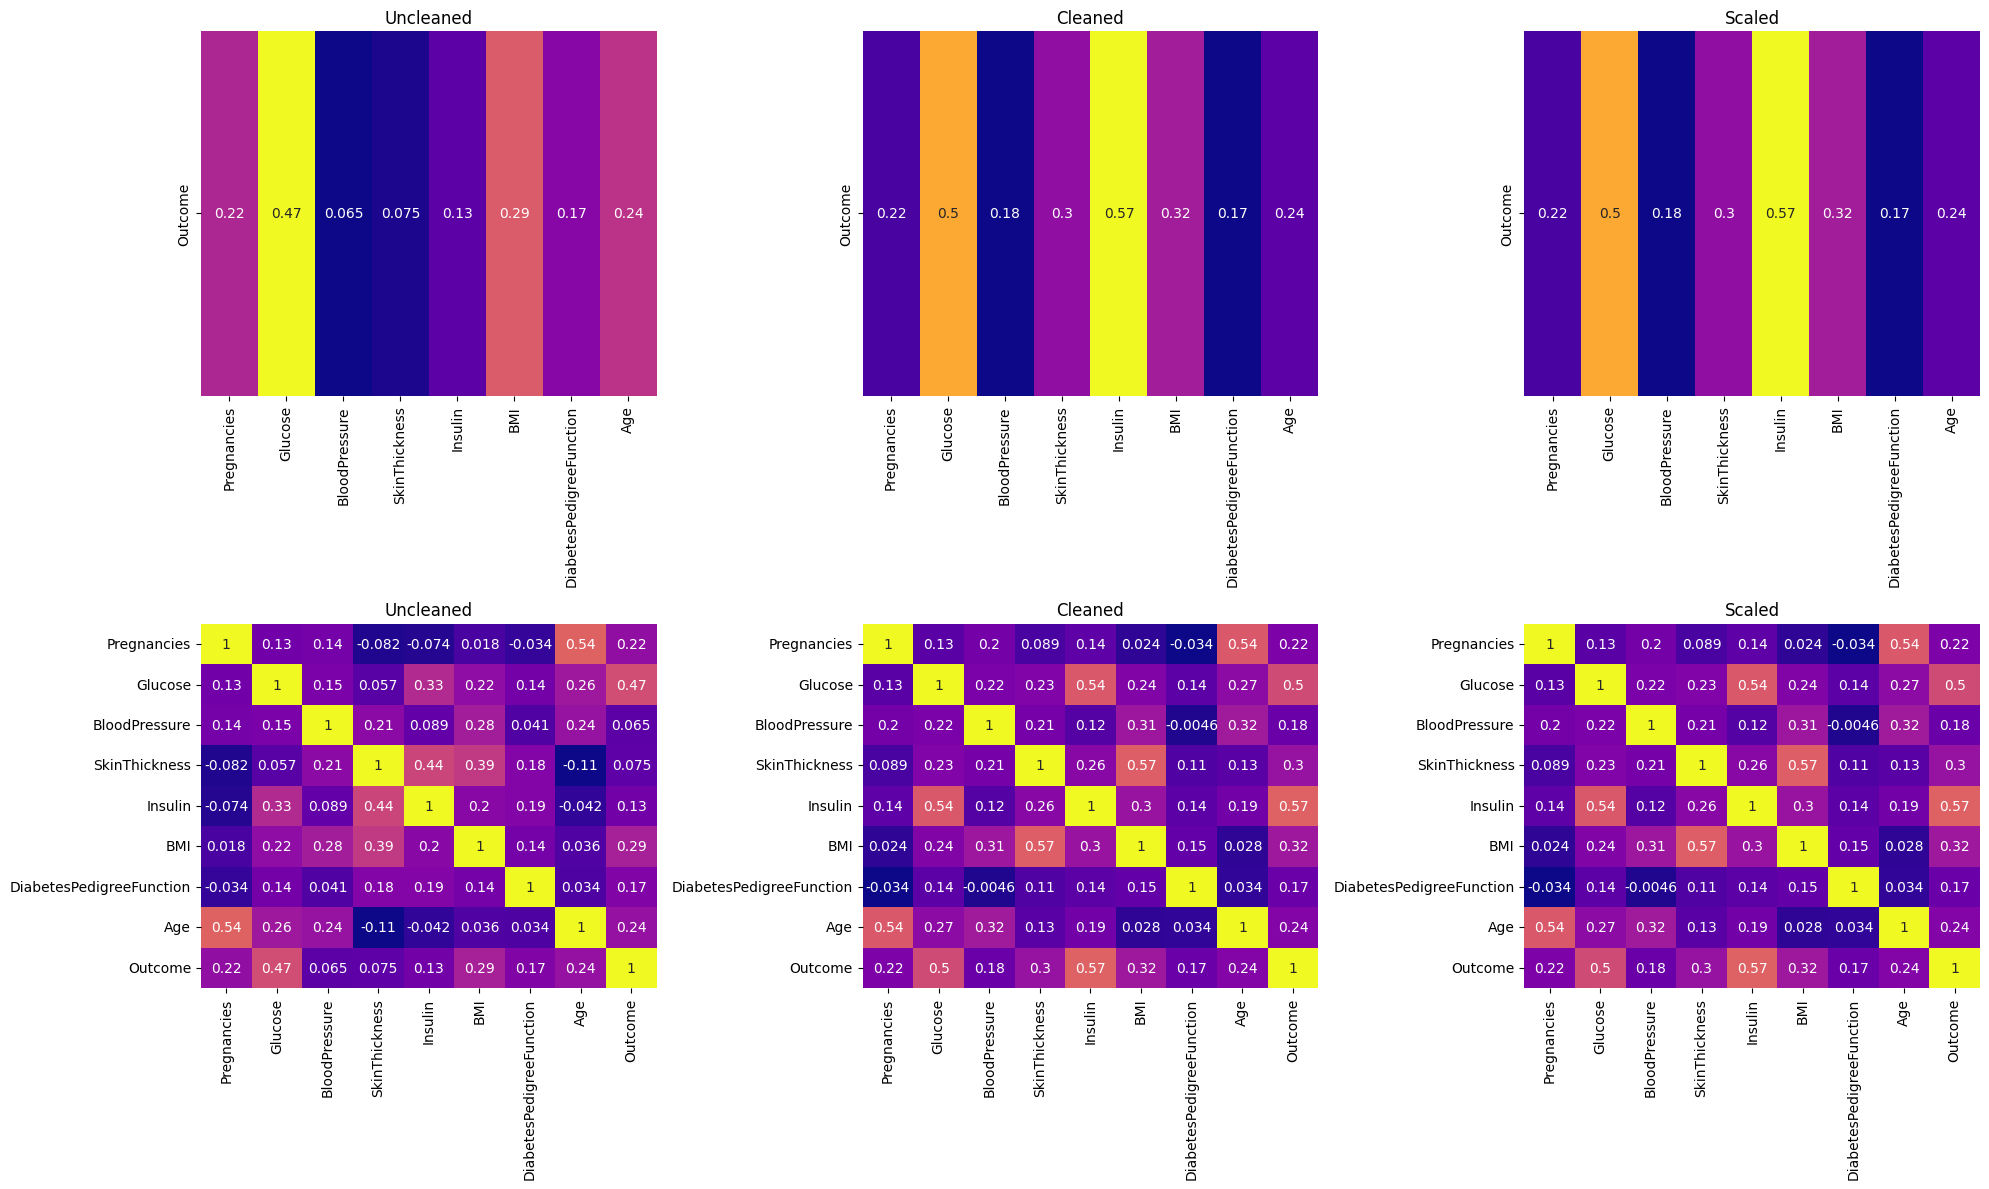

In [123]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
datasets = [df_uncleaned, df, df_Scaled]
titles = ['Uncleaned', 'Cleaned', 'Scaled']
for idx in range(3):
  sns.heatmap(datasets[idx].corr()['Outcome'].drop('Outcome').to_frame().T, yticklabels=True, cbar=False, cmap='plasma', annot=True, ax=axes[0, idx])
  axes[0, idx].set_title(titles[idx])


  sns.heatmap(datasets[idx].corr(), yticklabels=True, cbar=False, cmap='plasma', annot=True, ax=axes[1, idx])
  axes[1, idx].set_title(titles[idx])
plt.tight_layout()
plt.show()

### __Also we can see from the correlation matrix of uncleaned and cleaned data that we get better correlation__

In [124]:
def plot_scatter_plots(df, col_list_pairs, hue_col):
  n_cols = 3
  n_rows = math.ceil(len(col_list_pairs) / n_cols)
  fig, axes = plt.subplots(2,3, figsize=(20,12))
  axes = axes.flatten()

  for idx, (col1, col2) in enumerate(col_list_pairs):
    ax = axes[idx]
    sns.scatterplot(data = df, x = col1, y = col2, hue=hue_col, ax = ax)

    handles, labels = ax.get_legend_handles_labels()

    new_labels = []

    for label in labels:
      if label == '0':
        new_labels.append('Non Diabetic')
      else:
        new_labels.append('Diabetic')

    ax.legend(handles, new_labels, title='Outcome')

    ax.set_title(f'{col1} vs {col2}', fontweight='bold', fontsize=12)
    ax.set_xlabel(f'{col1}')
    ax.set_ylabel(f'{col2}')

  for j in range(idx+1, len(axes)): #Removing the extra unused subplots
    fig.delaxes(axes[j])
  plt.tight_layout(pad=4.0)
  plt.show()

### __Based on the correlation matrix, it is observed that multiple features have strong correlation amongst themselves. Hence we need to detect their effect on the target variable. Hence we plot scatter plots__

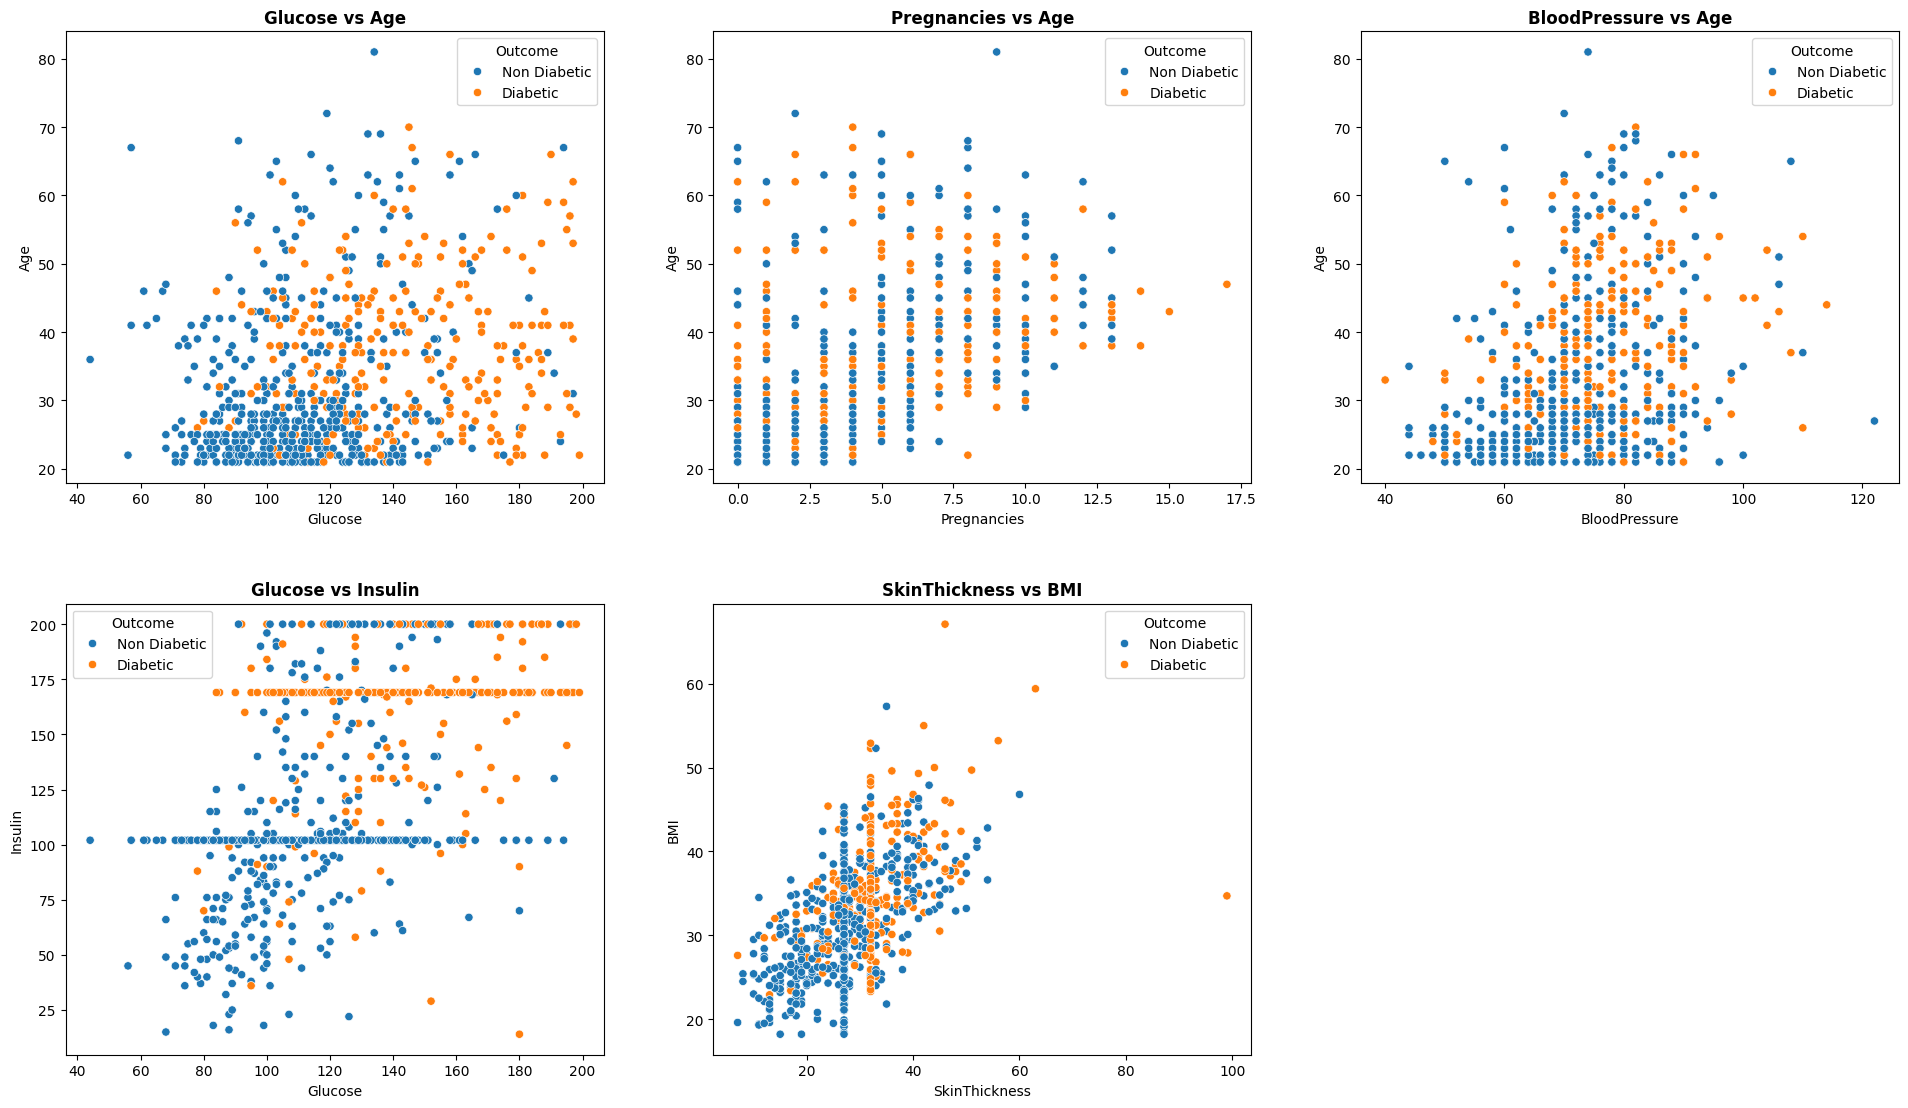

In [125]:
col_list_pairs = [('Glucose', 'Age'), ('Pregnancies', 'Age'), ('BloodPressure', 'Age'), ('Glucose', 'Insulin'), ('SkinThickness', 'BMI')]
plot_scatter_plots(df, col_list_pairs, 'Outcome')

# __2. Model Training and Prediction__

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [127]:
rf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=101)

In [128]:
X = df_Scaled[df_Scaled.columns[df_Scaled.columns != 'Outcome']]
y = df_Scaled['Outcome']
print(f"X shape {X.shape}")
print(f"y shape {y.shape}")

X shape (768, 8)
y shape (768,)


In [129]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.864625,-0.051724,0.665181,0.903215,0.169761,0.468492,1.425995
1,-0.844885,-1.204727,-0.564291,-0.010112,-0.535175,-0.848239,-0.365061,-0.190672
2,1.233880,2.014265,-0.735147,0.327535,0.903215,-1.328153,0.604397,-0.105584
3,-0.844885,-1.073339,-0.564291,-0.685405,-0.706924,-0.630096,-0.920763,-1.041549
4,-1.141852,0.503310,-2.785416,0.665181,0.881747,1.551333,5.484909,-0.020496


In [130]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [132]:
print(f"X train Shape {X_train.shape}")
print(f"y train Shape {y_train.shape}")
print(f"X test Shape {X_test.shape}")
print(f"y train Shape {y_test.shape}")

X train Shape (614, 8)
y train Shape (614,)
X test Shape (154, 8)
y train Shape (154,)


In [133]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=101)

In [134]:
rf_pred = rf.predict(X_test)

In [135]:
print(f"Random Forest Accuracy Score {round(accuracy_score(y_test, rf_pred) * 100,2)} %")

Random Forest Accuracy Score 88.96 %


In [136]:
print(f"Random Forest Classification Report\n\n {classification_report(y_test, rf_pred)}")

Random Forest Classification Report

               precision    recall  f1-score   support

           0       0.92      0.91      0.92       103
           1       0.83      0.84      0.83        51

    accuracy                           0.89       154
   macro avg       0.87      0.88      0.88       154
weighted avg       0.89      0.89      0.89       154



In [137]:
def build_confusion_matrix(y_test, rf_pred_1, rf_pred_2):
  conf_matrix_rf_1 = confusion_matrix(y_test, rf_pred_1)
  conf_matrix_rf_2 = confusion_matrix(y_test, rf_pred_2)
  tn_rf_1, fp_rf_1, fn_rf_1, tp_rf_1 = conf_matrix_rf_1.ravel()
  tn_rf_2, fp_rf_2, fn_rf_2, tp_rf_2 = conf_matrix_rf_2.ravel()

  conf_matrix_rf_1_labels = [[f'True Negative: {tn_rf_1}', f'False Positive: {fp_rf_1}'],
                      [f'False Negative: {fn_rf_1}', f'True Positive: {tp_rf_1}']]

  conf_matrix_rf_2_labels = [[f'True Negative: {tn_rf_2}', f'False Positive: {fp_rf_2}'],
                      [f'False Negative: {fn_rf_2}', f'True Positive: {tp_rf_2}']]


  fig, axes = plt.subplots(1, 2, figsize=(15, 6))
  sns.heatmap(conf_matrix_rf_1, annot=conf_matrix_rf_1_labels, fmt='', cbar=False, cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
  axes[0].set_xlabel('Predicted')
  axes[0].set_ylabel('Actual')
  axes[0].set_title('Confusion Matrix Random Forest(Cleaned Data)')



  sns.heatmap(conf_matrix_rf_2, annot=conf_matrix_rf_2_labels, fmt='', cbar=False, cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
  axes[1].set_xlabel('Predicted')
  axes[1].set_ylabel('Actual')
  axes[1].set_title('Confusion Matrix Random Forest(UnCleaned Data)')

In [138]:
auc_score = roc_auc_score(y_test, rf_pred)
print(f"AUC: {auc_score:.4f}")

AUC: 0.8779


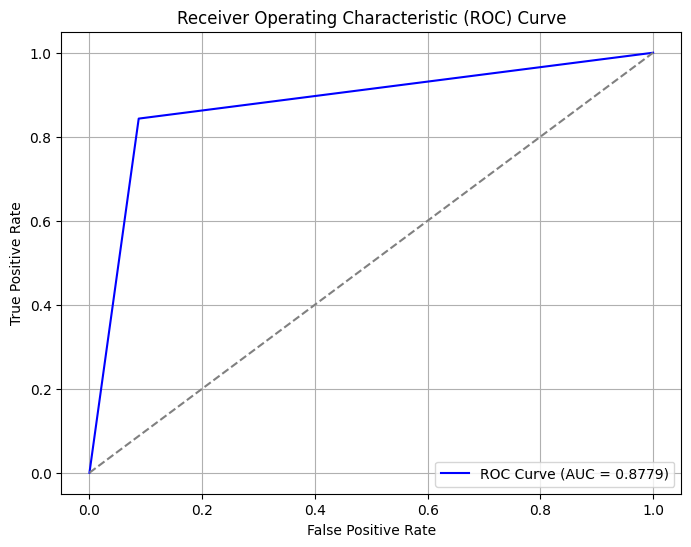

In [139]:
fpr, tpr, thresholds = roc_curve(y_test, rf_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Diagonal line indicating No classfication(Random guessing)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## __Now we shall train on uncleaned data__

In [140]:
rf_uncleaned = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=101)

In [141]:
X_uncleaned = df_uncleaned[df_uncleaned.columns[df_uncleaned.columns != 'Outcome']]
y_uncleaned = df_uncleaned['Outcome']
print(f"X shape {X_uncleaned.shape}")
print(f"y shape {y_uncleaned.shape}")

X shape (768, 8)
y shape (768,)


In [142]:
X_train_uncleaned, X_test_uncleaned, y_train_uncleaned, y_test_uncleaned = train_test_split(X_uncleaned, y_uncleaned, test_size=0.2, random_state=101)

In [143]:
rf_uncleaned.fit(X_train_uncleaned, y_train_uncleaned)

RandomForestClassifier(max_depth=5, random_state=101)

In [144]:
rf_uncleaned_pred = rf_uncleaned.predict(X_test_uncleaned)

In [145]:
print(f"Random Forest Accuracy Score {round(accuracy_score(y_test, rf_uncleaned_pred) * 100,2)} %")

Random Forest Accuracy Score 77.27 %


In [146]:
print(f"Random Forest Classification Report\n\n {classification_report(y_test, rf_uncleaned_pred)}")

Random Forest Classification Report

               precision    recall  f1-score   support

           0       0.79      0.90      0.84       103
           1       0.72      0.51      0.60        51

    accuracy                           0.77       154
   macro avg       0.76      0.71      0.72       154
weighted avg       0.77      0.77      0.76       154



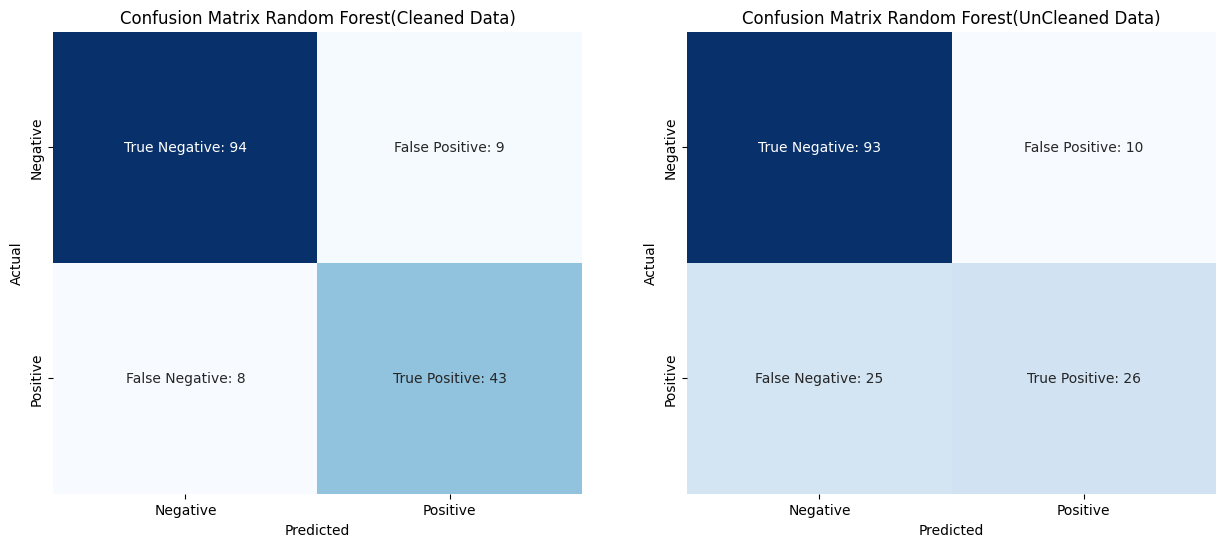

In [147]:
#Confusion Matrix on cleaned and uncleaned data
build_confusion_matrix(y_test, rf_pred, rf_uncleaned_pred)

In [148]:
auc_score = roc_auc_score(y_test, rf_uncleaned_pred)
print(f"AUC: {auc_score:.4f}")

AUC: 0.7064


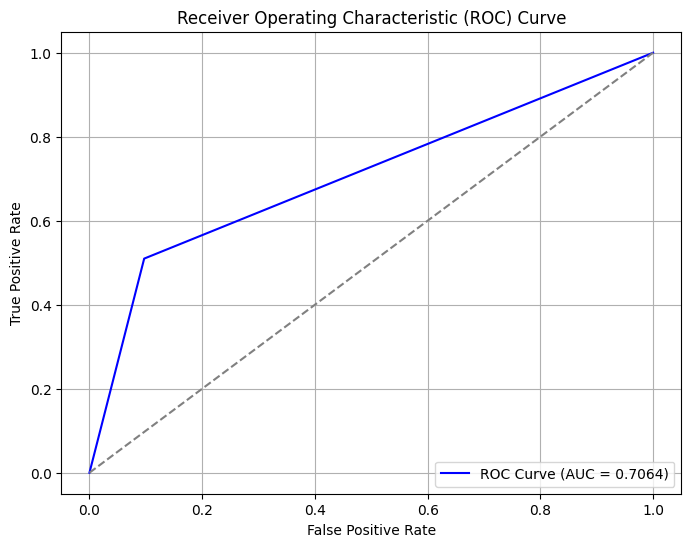

In [149]:
fpr, tpr, thresholds = roc_curve(y_test, rf_uncleaned_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Diagonal line indicating No classfication(Random guessing)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### __After performing model training and various metric evaluation like AUC and plotting ROC and the comparing the accuracies, recall and precision, it is clearly evident that the RandomForestClassifier is performing well on cleaned data rather than on uncleaned data__

###  __Accuracy of RF on Cleaned Data: 88.96 %__
###  __Accuracy of RF on UnCleaned Data: 77.27 %__

<Axes: xlabel='Model', ylabel='Accuracy'>

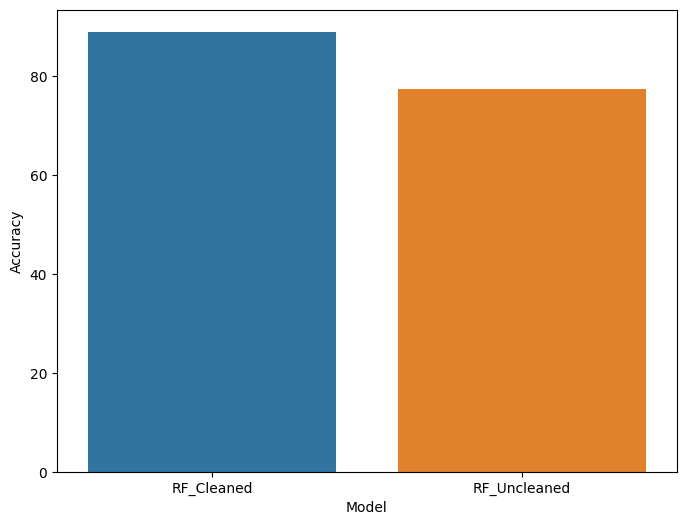

In [150]:
model_accuracies= [round(accuracy_score(y_test, rf_pred) * 100,2), round(accuracy_score(y_test, rf_uncleaned_pred) * 100,2)]
labels = ['RF_Cleaned', 'RF_Uncleaned']

model_accuracy_df = pd.DataFrame({'Model': labels, 'Accuracy': model_accuracies})

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=model_accuracy_df, hue=labels)


# __3. Lifecycle Questions:__

## __a. What would go wrong in the lifecycle if preprocessing is skipped?__

__Answer:__ Problems that would occur if preprocessing is skipped:

 __1. Many features like Glucose, BMI, Insulin, etc. contain value 0 which is physiologically impossible. if these are not handled then the model will treat them as valid data and act accordingly__

 __2. If feature scaling is not performed properly on the feature columns, models will be biased toward features with larger scales.__

## __b. Now, based on your own coding experience (in this lab or elsewhere), explain whether this problem could have been identified or prevented using only normal programming practices. Justify with one concrete example from your own implementation or learning__

__Answer:__ Normal programming practices like writing clean, readable, reusable and maintainable code are essential for software development but may not be enough to handle cases of missing data or outliers

__1.__ Explicit checks for missing data needs to be putin place like in this case even when the dataset contained no null values  but it contained rather absurd or medically impossible value __0__ for certain features like __Glucose, BMI, Insulin, etc.__

__2.__ Handling outliers, feature scaling and encoding data require not only good programming practices but also the domain knowledge which helps the model to perform better.

__Example__ Similar to this dataset I had worked on a dataset which contained string values "NaN" in the dataset so normal .isna() or similar functions were not enough to handle these and model performance was very bad. After handling these manually and scaling the features, the model performance worked up significantly.